# **Projet Big Data - Deep Learning**
# Dani Halegua - Luca Champesting - Idyano Leroy

Le but de ce projet est d'utiliser les méthodes de Deep Learning vues en cours et en Tp dans le but d'entraîner plusieurs réseaux de neurones à classifier des images de paysage. On analysera les performances obtenues pour en tirer des conclusions.


In [123]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import RMSprop, Adam

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16

#IMPORTATIONS UTILES AU PROJET





***1ère étape*** : Récupération du jeu de données et création de deux générateurs train et val qui nous permettent de charger les images dans la RAM seulement quand c'est nécessaire. Le preprocessing (standardisation des images et division en un jeu d'apprentissage de 80% et un jeu de test de 20%) est géré par les générateurs.

In [4]:
!wget https://github.com/ml5js/ml5-data-and-models/raw/master/datasets/images/landscapes/landscapes_small.zip
!mkdir landscapes
!unzip landscapes_small.zip -d landscapes
!rm -r landscapes/__MACOSX

--2022-02-13 18:26:43--  https://github.com/ml5js/ml5-data-and-models/raw/master/datasets/images/landscapes/landscapes_small.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ml5js/ml5-data-and-models/master/datasets/images/landscapes/landscapes_small.zip [following]
--2022-02-13 18:26:43--  https://raw.githubusercontent.com/ml5js/ml5-data-and-models/master/datasets/images/landscapes/landscapes_small.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81935123 (78M) [application/zip]
Saving to: ‘landscapes_small.zip’

landscapes_small.zi 100%[===================>]  78.14M   230MB/s    in 0.3s 

In [9]:


input_dir = 'landscapes'

seed = 1
 
data_generator = ImageDataGenerator(
    rescale = 1. / 255,                         #normalisation
    validation_split = 0.2)                     #division en train et val

train_generator = data_generator.flow_from_directory(
    input_dir, 
    target_size =(256, 256),    #taille des images
    batch_size = 32,
    class_mode = 'categorical',
    seed = seed,
    subset='training')

validation_generator = data_generator.flow_from_directory( 
    input_dir, 
    target_size =(256, 256), 
    batch_size = 32,
    class_mode = 'categorical',
    seed = seed,
    shuffle = False,               # On mélange pas les images du test pour pouvoir afficher les prédictions
    subset='validation')

Found 3026 images belonging to 7 classes.
Found 755 images belonging to 7 classes.


In [77]:
labels = {value: key for key, value in train_generator.class_indices.items()}

for key, value in labels.items():
    print(f"{key} : {value}")

0 : city
1 : field
2 : forest
3 : lake
4 : mountain
5 : ocean
6 : road


Notre dataset possède 7 classes d'image : ville, champ, forêt, lac, montagne, ocean et route. Essayons d'afficher quelques images!

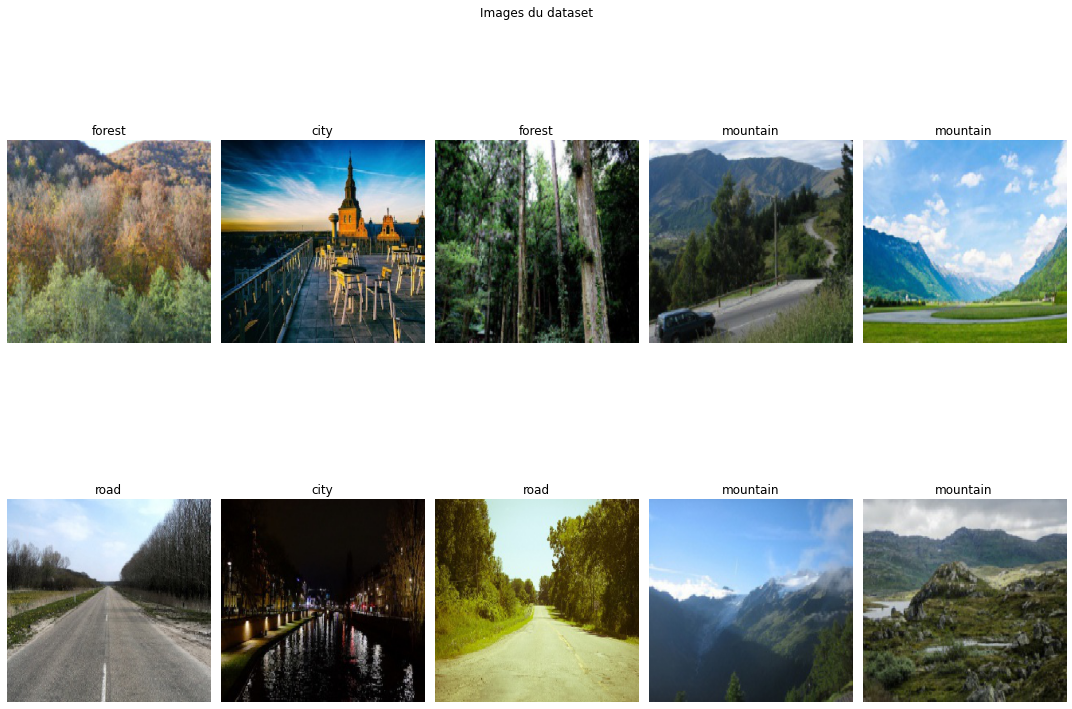

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Images du dataset")
plt.show()

In [ ]:
X_train, y_train = next(train_generator)

In [ ]:
print(X_train.shape,y_train.shape)   #taille
print(X_train.min(), X_train.max(),y_train.min(),y_train.max())
 

(32, 256, 256, 3) (32, 7)
0.0 1.0 0.0 1.0


# CNN

***2è étape :*** On va maintenant entraîner un modèle basique de réseau de neurones convolutifs qui sont adaptés à la classification d'image. Notre modèle aura l'architecture suivante : 

*   ``Conv2D`` : filter: 16, kernel: (3,3), activation = 'relu', input_shape : (256,256,3); images RGB de taille 256 x 256  
*   ``MaxPooling2D`` : kernel(2,2)
* ``Conv2D`` : filter:32, kernel (3,3), activation = 'relu'
*   ``MaxPooling2D`` : kernel(2,2)
* ``Conv2D`` : filter:32, kernel (3,3), activation = 'relu'
*`` Flatten`` pour applatir les matrices en sortie sous forme de vecteurs
* ``Dense`` : units :32, activation = 'relu'
* ``Dense`` : units:7, activation ='softmax' pour retourner les probabilités associées à chaque classe.


Comme fonction coût on utilisera l'entropie croisée qui est adaptée à la classification multi-classe et comme optimiseur on utilisera ``Adam`` qui semble être l'optimiseur le plus performant. On entraînera notre réseau sur 20 epochs avec un ``batch_size`` = 32.

In [ ]:


num_classes = 7

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 115200)            0

In [6]:
def plot_learning_curves(history):                       #Pour afficher l'évolution de notre modèle
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/20
64/64 [==============================] - 14s 86ms/step - loss: 2.4371 - accuracy: 0.3398 - val_loss: 0.9364 - val_accuracy: 0.6812
Epoch 2/20
64/64 [==============================] - 8s 131ms/step - loss: 1.3461 - accuracy: 0.5029 - val_loss: 0.7783 - val_accuracy: 0.7219
Epoch 3/20
64/64 [==============================] - 5s 83ms/step - loss: 1.0521 - accuracy: 0.6283 - val_loss: 0.7758 - val_accuracy: 0.7469
Epoch 4/20
64/64 [==============================] - 6s 100ms/step - loss: 0.8977 - accuracy: 0.6740 - val_loss: 0.8160 - val_accuracy: 0.6875
Epoch 5/20
64/64 [==============================] - 5s 82ms/step - loss: 0.8241 - accuracy: 0.7085 - val_loss: 0.7112 - val_accuracy: 0.7719
Epoch 6/20
64/64 [==============================] - 5s 82ms/step - loss: 0.6808 - accuracy: 0.7480 - val_loss: 0.7264 - val_accuracy: 0.7375
Epoch 7/20
64/64 [==============================] - 5s 81ms/step - loss: 0.5444 - accuracy: 0.8063 - val_loss: 0.7778 - val_accuracy: 0.7688
Epoch 8/20

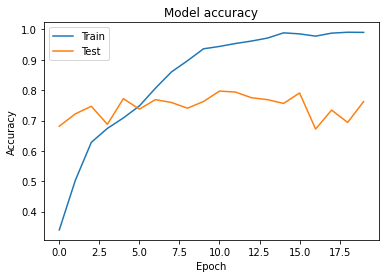

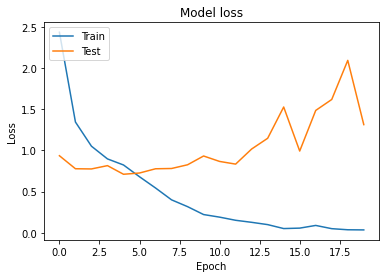

In [ ]:


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=64,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=10)

plot_learning_curves(history)


On observe que notre modèle est très performant sur la partie train avec un score de 0.99 après 20 epoques. Cependant on voit aussi que le score sur la partie test est nettement inférieur (0.76), et fluctue énormément. Notre modèle a du mal à généraliser. C'est un cas classique d'over-fitting. La prochaine étape consiste alors à faire en sorte que notre modèle améliore sa capacité de généralisation.

# Amélioration du modèle
Il existe plusieurs méthodes pour améliorer la capacité de généralisation d'un modèle de réseau de neurones. Dans ce projet nous testerons 3 méthodes :


*   Data Augmentation
*   Batch normalization 
*   Dropout layers


# Data augmentation
***3ème étape :***  Pour améliorer les performances d'un modèle de deep learning, la méthode la plus utilisée est la méthode d'augmentation des données. Le but est d'augmenter la nombre d'images en effectuant de légères modifications sur les images déjà existantes (zoom, rotation, ajout de bruit, modification de la couleur...). Grâce à cette augmentation de données le modèle devrait réussir à mieux apprendre sur l'échantillon d'apprentissage et donc à moins over-fitter.
Pour effectuer la data augmentation, on va utiliser ``ImageDataGenerator`` de Keras qui nous permet d'ajouter des images modifiées à notre dataset. 
On va également rajouter un callback ``ReduceLROnPlateau`` qui permet de réduire le learning rate quand notre fonction coût ne s'améliore pas. 
Ensuite on utilisera le même modèle que précedemment pour l'entraînement.

In [13]:

augmenting_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,     #zoom
                                  width_shift_range=0.2,  #rotations
                                  height_shift_range=0.2, #rotations
                                  fill_mode='nearest')



train_generator = augmenting_datagen.flow_from_directory(
    input_dir, 
    target_size =(256, 256), 
    batch_size = 32,
    class_mode = 'categorical',
    seed = seed,
    subset='training')

Found 3781 images belonging to 7 classes.


On affiche un exemple de data augmentation sur une image

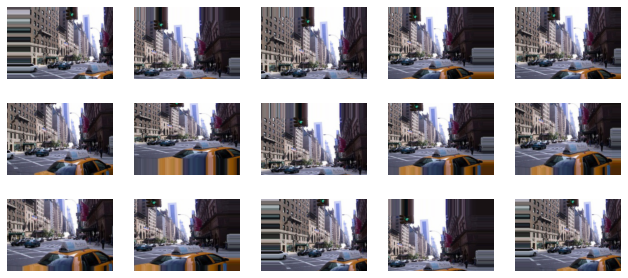

In [110]:


images = train_generator.filenames
test_img = np.asarray(images)


img = load_img(os.path.join(input_dir,'city','3715538_4fc63bc071.jpg'  ))
X =np.array(img)
plt.figure(figsize=(11, 5))
flow = augmenting_datagen.flow(X[np.newaxis, :, :, :])
for i, X_augmented in zip(range(15), flow):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_augmented[0])
    plt.axis('off')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
64/64 [==============================] - 29s 445ms/step - loss: 1.8972 - accuracy: 0.2891 - val_loss: 1.3983 - val_accuracy: 0.4450 - lr: 0.0010
Epoch 2/20
64/64 [==============================] - 28s 434ms/step - loss: 1.4318 - accuracy: 0.4453 - val_loss: 1.3111 - val_accuracy: 0.4927 - lr: 0.0010
Epoch 3/20
64/64 [==============================] - 28s 433ms/step - loss: 1.2853 - accuracy: 0.4894 - val_loss: 1.1888 - val_accuracy: 0.5444 - lr: 0.0010
Epoch 4/20
64/64 [==============================] - 28s 437ms/step - loss: 1.2806 - accuracy: 0.5101 - val_loss: 1.0010 - val_accuracy: 0.6424 - lr: 0.0010
Epoch 5/20
64/64 [==============================] - 28s 436ms/step - loss: 1.1955 - accuracy: 0.5344 - val_loss: 0.9189 - val_accuracy: 0.6397 - lr: 0.0010
Epoch 6/20
64/64 [==============================] - 28s 439ms/step - loss: 1.1237 - accuracy: 0.5796 - val_loss: 0.9550 - val_accuracy: 0.6424 - lr: 0.0010
Epoch 7/20
64/64 [==============================] - 28s 441ms/st

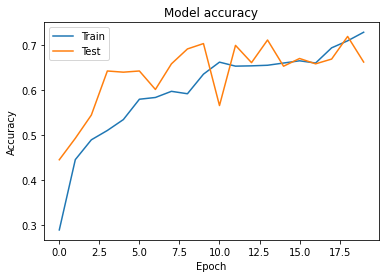

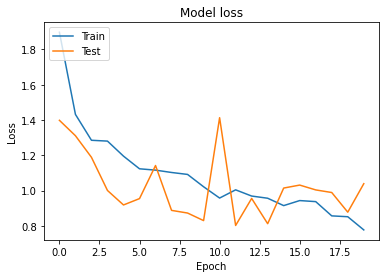

In [14]:



num_classes = 7

model_da = Sequential()
model_da.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_da.add(MaxPooling2D((2, 2)))
model_da.add(Conv2D(32, (3, 3), activation='relu'))
model_da.add(MaxPooling2D((2, 2)))
model_da.add(Conv2D(32, (3, 3), activation='relu'))
model_da.add(Flatten())
model_da.add(Dense(32, activation='relu'))
model_da.add(Dense(num_classes, activation='softmax'))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

model_da.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])



history = model_da.fit_generator(
      train_generator,
      steps_per_epoch=64,
      epochs=20,
      validation_data=validation_generator,
      callbacks=[reduce_lr])

plot_learning_curves(history)

Il semblerait que notre modèle mette trop de temps à apprendre correctement (précision de 0.72 au bout de 20 epoques). Les résultats sur le test set sont sensiblement les mêmes que précedemment. Peut être qu'il faudrait faire tourner notre modèle plus longtemps, cependant le modèle sans la data augmentation semble plus performant et bien plus rapide.

# Batch normalization 
***4ème étape :*** Après avoir vu que la technique d'augmentation des données ne semblent pas très performante dans le cas présent, on peut essayer d'améliorer notre modèle grâce à la batch normalization. 

La batch normalization est une technique de normalisation qui est effectuée en sortie de chaque couche de notre réseau de neurones de convolution. La normalisation est effectuée sur des mini-batchs plutôt que sur le dataset en entier. 
Le but est d'accélérer l'entrainement et de rendre le modèle plus stable.

In [21]:
train_generator = data_generator.flow_from_directory(
    input_dir, 
    target_size =(256, 256),    #taille des images
    batch_size = 32,
    class_mode = 'categorical',
    seed = seed,
    subset='training')


validation_generator = data_generator.flow_from_directory( 
    input_dir, 
    target_size =(256, 256), 
    batch_size = 32,
    class_mode = 'categorical',
    seed = seed,
    shuffle = False,               # On mélange pas les images du test pour pouvoir afficher les prédictions
    subset='validation')

Found 3026 images belonging to 7 classes.
Found 755 images belonging to 7 classes.


In [22]:



num_classes = 7

model_bn = Sequential()
model_bn.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_bn.add(BatchNormalization())
model_bn.add(MaxPooling2D((2, 2)))
model_bn.add(Conv2D(32, (3, 3), activation='relu'))
model_bn.add(BatchNormalization())
model_bn.add(MaxPooling2D((2, 2)))
model_bn.add(Conv2D(32, (3, 3), activation='relu'))
model_bn.add(BatchNormalization())
model_bn.add(Flatten())
model_bn.add(Dense(32, activation='relu'))
model_bn.add(BatchNormalization())
model_bn.add(Dense(num_classes, activation='softmax'))



model_bn.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_12 (Bat  (None, 254, 254, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_13 (Bat  (None, 125, 125, 32)     128       
 chNormalization)                                                
                                                      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/20
64/64 [==============================] - 7s 101ms/step - loss: 1.2543 - accuracy: 0.5580 - val_loss: 2.7722 - val_accuracy: 0.1152 - lr: 0.0010
Epoch 2/20
64/64 [==============================] - 7s 107ms/step - loss: 0.8292 - accuracy: 0.7030 - val_loss: 3.6648 - val_accuracy: 0.1152 - lr: 0.0010
Epoch 3/20
64/64 [==============================] - 6s 97ms/step - loss: 0.6142 - accuracy: 0.7930 - val_loss: 2.8620 - val_accuracy: 0.2344 - lr: 0.0010
Epoch 4/20
64/64 [==============================] - 8s 120ms/step - loss: 0.4091 - accuracy: 0.8736 - val_loss: 2.6461 - val_accuracy: 0.2119 - lr: 0.0010
Epoch 5/20
64/64 [==============================] - 6s 97ms/step - loss: 0.2480 - accuracy: 0.9307 - val_loss: 2.4317 - val_accuracy: 0.2397 - lr: 0.0010
Epoch 6/20
64/64 [==============================] - 6s 97ms/step - loss: 0.1532 - accuracy: 0.9612 - val_loss: 1.2995 - val_accuracy: 0.5073 - lr: 0.0010
Epoch 7/20
64/64 [==============================] - 6s 97ms/step - loss: 

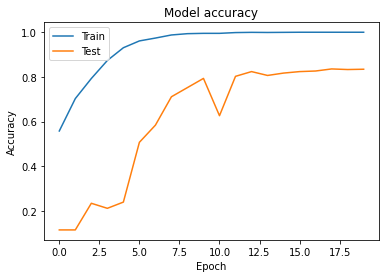

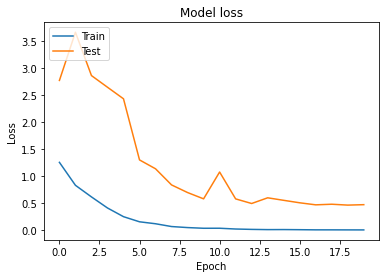

In [23]:
model_bn.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])



history = model_bn.fit_generator(
      train_generator,
      steps_per_epoch=64,
      epochs=20,
      validation_data=validation_generator,
      callbacks=[reduce_lr])

plot_learning_curves(history)

Cette méthode semble très performante, on voit bien que le modèle apprend très rapidement sur l'échantillon d'apprentissage (accuracy de 0.99 en 9 epoques), et que la précision de l'échantillon de test ne fluctue plus, c'est à dire qu'on a plus d'over-fitting avec une précision finale à 0.83.

# Dropout layers + régularisation
***5ème étape :*** On peut également essayer de mettre des couches de Dropout dans notre CNN. Une couche de dropout est un masque qui nullifie la contribution de certains neurones au sein d'une couche de neurones. Les couches de dropout sont importants dans l'entrainement des CNN parce qu'elles permettent de limiter l'over-fitting sur l'echantillon d'apprentissage. 
En effet, si elles ne sont pas présentes, le premier batch influence l'apprentissage de manière disproportionnée. C'est pourquoi on va rajouter une couche de dropout au tout début de notre modèle.
Notre modèle étant relativement petit, on choisira un taux de dropout à 10%, c'est à dire qu'un neurone sur dix sera nullifié.

On va également rajouter une régularisation l2 dans nos couches de convolution dans le but de limiter l'over-fitting au maximum.

In [34]:



num_classes = 7

model_do = Sequential()
model_do.add(Dropout(0.1,input_shape=(256, 256, 3)))
model_do.add(Conv2D(16, (3, 3), activation='relu'))
model_do.add(Dropout(0.1))
model_do.add(MaxPooling2D((2, 2)))
model_do.add(Conv2D(16, (3, 3), activation='relu',kernel_regularizer=l2(0.00005)))
model_do.add(Dropout(0.1))
model_do.add(MaxPooling2D((2, 2)))
model_do.add(Conv2D(16, (3, 3), activation='relu',kernel_regularizer=l2(0.00005)))
model_do.add(Dropout(0.1))
model_do.add(Flatten())
model_do.add(Dense(32, activation='relu'))
model_do.add(Dropout(0.1))
model_do.add(Dense(num_classes, activation='softmax'))



model_do.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_30 (Dropout)        (None, 256, 256, 3)       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 dropout_31 (Dropout)        (None, 254, 254, 16)      0         
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 125, 125, 16)      2320      
                                                                 
 dropout_32 (Dropout)        (None, 125, 125, 16)      0         
                                                     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/20
64/64 [==============================] - 7s 103ms/step - loss: 1.7323 - accuracy: 0.3184 - val_loss: 1.5299 - val_accuracy: 0.4093 - lr: 0.0010
Epoch 2/20
64/64 [==============================] - 6s 100ms/step - loss: 1.3624 - accuracy: 0.4671 - val_loss: 1.4711 - val_accuracy: 0.4675 - lr: 0.0010
Epoch 3/20
64/64 [==============================] - 6s 98ms/step - loss: 1.2183 - accuracy: 0.5329 - val_loss: 1.3182 - val_accuracy: 0.5219 - lr: 0.0010
Epoch 4/20
64/64 [==============================] - 6s 98ms/step - loss: 1.0736 - accuracy: 0.5981 - val_loss: 1.2140 - val_accuracy: 0.5603 - lr: 0.0010
Epoch 5/20
64/64 [==============================] - 6s 97ms/step - loss: 1.0018 - accuracy: 0.6062 - val_loss: 1.1988 - val_accuracy: 0.5974 - lr: 0.0010
Epoch 6/20
64/64 [==============================] - 6s 97ms/step - loss: 0.8853 - accuracy: 0.6681 - val_loss: 1.1176 - val_accuracy: 0.6278 - lr: 0.0010
Epoch 7/20
64/64 [==============================] - 6s 98ms/step - loss: 0

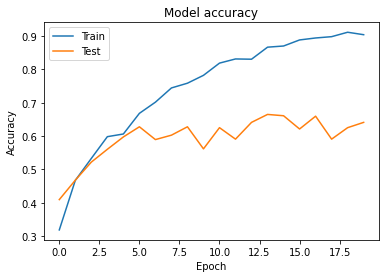

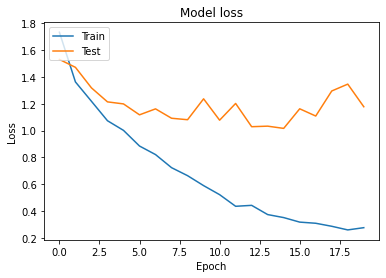

In [35]:
model_do.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])



history = model_do.fit_generator(
      train_generator,
      steps_per_epoch=64,
      epochs=20,
      validation_data=validation_generator,
      callbacks=[reduce_lr])

plot_learning_curves(history)

Il semblerait que cette technique ne soit pas très performante, en effet on obtient un score de 0.64 sur le jeu test, ce qui semble assez faible et de plus même si l'over-fitting a été limité, il est toujours présent.

# Transfert learning
***6ème étape :*** On peut à présent utiliser une des techniques les plus utilisées en deep learning : le transfert learning.
Le but du transfert learning est de ré-utiliser un modèle performant déjà entrainé pour une tâche similaire (ici la classification d'images) dans le but d'améliorer notre propre modèle.

Plus précisément, les 4 étapes du transfert learning sont les suivantes :

*   Charger un modèle déjà entrainé avec les poids qu'il a appris
*   Freeze toutes ses couches en fixant ``trainable = False `` (pour éviter de détruire les informations obtenues par le modèle de base) 
*   Rajouter un petit modèle de classification en sortie du modèle de base pour prédire à l'aide des anciennes features
*  Entrainer notre nouveau modèle sur notre dataset.


Pour ce faire, on utilisera le réseau VGG16 d'ImageNet. VGG16 est un algorithme très performant et très utilisé en computer vision. On récupèrera les poids issus de l'entraînement effectué sur ImageNet auquel on rajoutera un petit réseau possèdant l'architecture suivante :

*   ``Flatten``
*   ``Dense``(units = 256, activation = 'relu')
* ``Dense`` (units=7, activation='softmax ) pour associer une prédiction finale pour chaque image à chaque classe.




In [113]:

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))

In [68]:
conv_base.trainable = False

model_vgg16 = Sequential()
model_vgg16.add(conv_base)
model_vgg16.add(Flatten())
model_vgg16.add(Dense(256, activation='relu'))
model_vgg16.add(Dense(7, activation='softmax'))

model_vgg16.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_17 (Flatten)        (None, 32768)             0         
                                                                 
 dense_39 (Dense)            (None, 256)               8388864   
                                                                 
 dense_40 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 23,105,351
Trainable params: 8,390,663
Non-trainable params: 14,714,688
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/20
64/64 [==============================] - 8s 114ms/step - loss: 1.2944 - accuracy: 0.6072 - val_loss: 0.6977 - val_accuracy: 0.8813
Epoch 2/20
64/64 [==============================] - 6s 100ms/step - loss: 0.6827 - accuracy: 0.8215 - val_loss: 0.5443 - val_accuracy: 0.8656
Epoch 3/20
64/64 [==============================] - 6s 100ms/step - loss: 0.5000 - accuracy: 0.8791 - val_loss: 0.4181 - val_accuracy: 0.8813
Epoch 4/20
64/64 [==============================] - 6s 100ms/step - loss: 0.4166 - accuracy: 0.8943 - val_loss: 0.4180 - val_accuracy: 0.8562
Epoch 5/20
64/64 [==============================] - 6s 100ms/step - loss: 0.3464 - accuracy: 0.9135 - val_loss: 0.4249 - val_accuracy: 0.8781
Epoch 6/20
64/64 [==============================] - 6s 100ms/step - loss: 0.2973 - accuracy: 0.9326 - val_loss: 0.2883 - val_accuracy: 0.9125
Epoch 7/20
64/64 [==============================] - 6s 101ms/step - loss: 0.2676 - accuracy: 0.9376 - val_loss: 0.3021 - val_accuracy: 0.9094
Epoch 

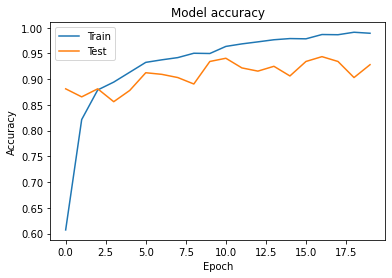

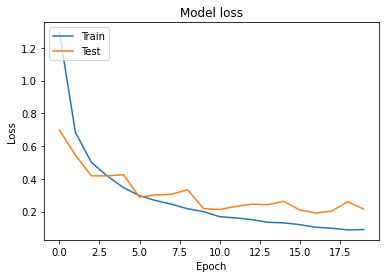

In [69]:


model_vgg16.compile(optimizer=Adam(learning_rate=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

              
history = model_vgg16.fit_generator(
      train_generator,
      steps_per_epoch=64,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=10)

plot_learning_curves(history)


Bingo ! Le transfert learning a grandement amélioré les performances de notre modèle, avec un accuracy de 0.93 sur le test set. Il a également fais disparaître l'over-fitting.

# Tableau récapulatif

Les résultats de tous nos réseaux de neurones sont récapitulés dans le tableau suivant. Les scores sont ceux de la dernière époque.

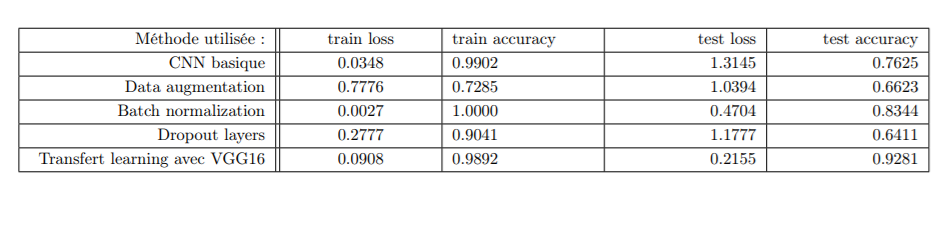

On voit bien dans ce tableau que le transfert learning a obtenu de loin les meilleurs scores suivi de la méthode de batch normalization. On peut aussi remarquer que la méthode de data augmentation a du mal à apprendre rapidement sur le train set.

# Evaluation du modèle

Maintenant que l'on connait notre meilleur modèle, on peut analyser et évaluer plus en détail les prédictions qu'il effectue.
Pour ce faire on affichera la matrice de confusion, ainsi que quelques images sur lequel notre réseau se trompe.

In [72]:
predictions = model_vgg16.predict(validation_generator)

In [73]:
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

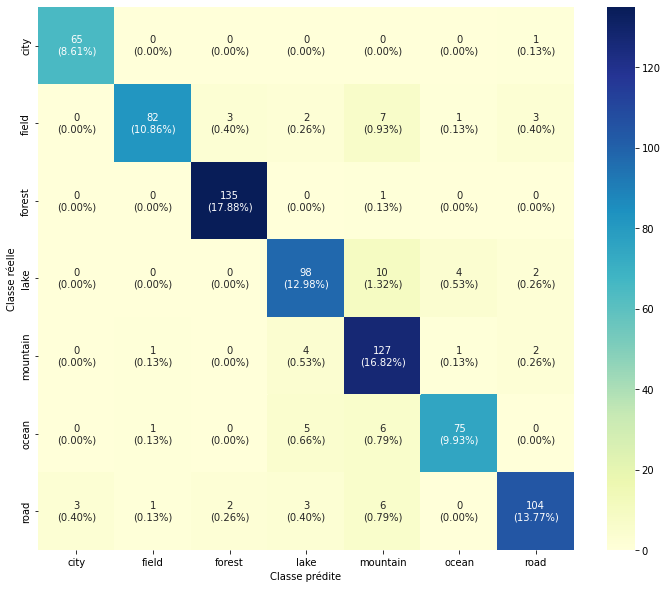

In [78]:


labels = {value: key for key, value in train_generator.class_indices.items()}
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(7, 7)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.show()

On observe que notre réseau se trompe le plus souvent entre les lacs et les montagnes : 10 images de lac sur 116 soit 8% qu'il prédit comme montagne. On observe également qu'il ne se trompe presque jamais (1 seule faute) sur les images de forêt et de ville.

Affichons certaines de ses mauvaises prédictions :

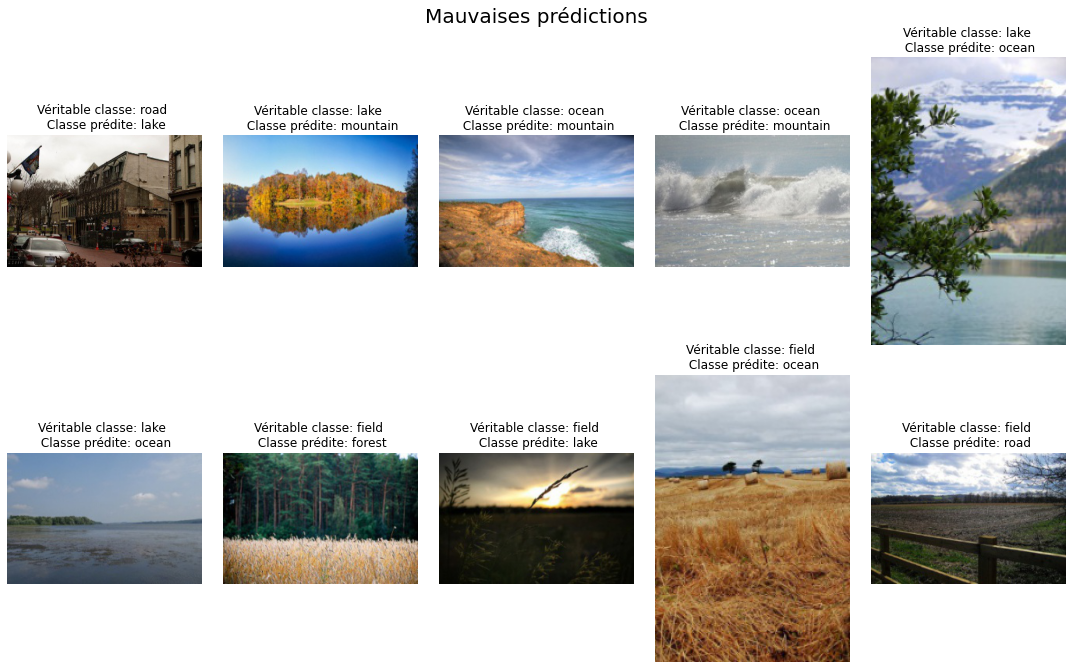

In [99]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]


test_images = validation_generator.filenames
test_img = np.asarray(test_images)[errors]


fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"Véritable classe: {true_label} \n Classe prédite: {predicted_label}")
        img_path = os.path.join(input_dir, test_img[idx])
        img = plt.imread(img_path)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Mauvaises prédictions', fontsize=20)
plt.show()

# t-SNE
On va maintenant visualiser les features calculées par le modèle VGG16 en 2D grâce à l'algorithme t-SNE. Pour qu'on ait pas à travailler sur un espace trop grand, on procédera au préalable à une PCA qui nous permettra de réduire l'espace des features à une dimension de 50 et ainsi accélérer la vitesse d'éxécution. On travaillera avec un sous-ensemble de 500 images.  

In [116]:

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 512))    #taille de sortie de la dernière couche de VGG16
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='sparse')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [118]:
features, labels = extract_features(input_dir, 500)
features = np.reshape(features, (500, 8 * 8 * 512))

Found 3781 images belonging to 7 classes.


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


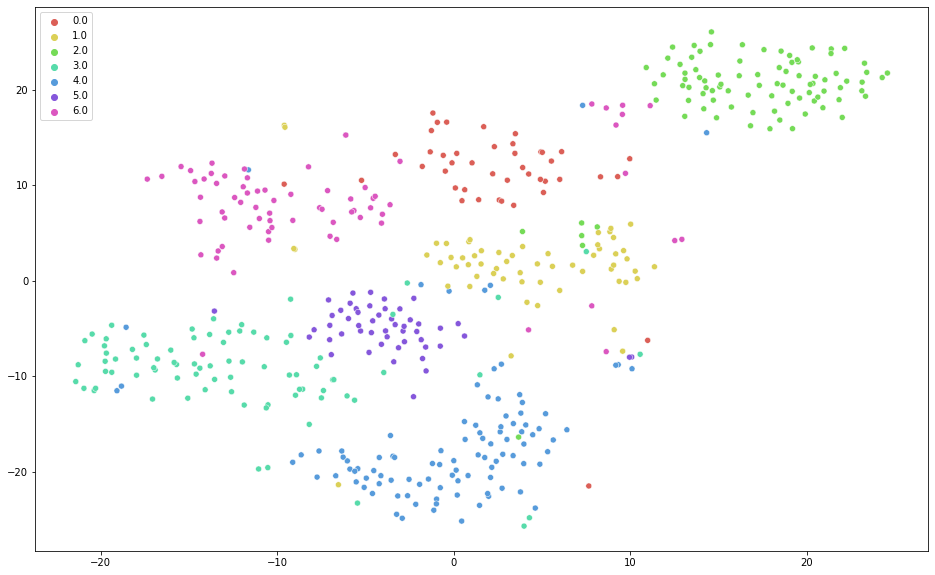

In [122]:

X_pca = PCA(n_components = 50)
X_pca = X_pca.fit_transform(features)
X_tsne = TSNE()
X_tsne  = X_tsne.fit_transform(X_pca)



plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=labels,
    palette=sns.color_palette("hls", 7),
    legend="full",
)

Pour finir ce projet, on va choisir une image au hasard dans le dataset et afficher les 3 images qui sont le plus proches de l'image choisie au sens de la distance euclidienne dans l'espace des features.

